In [2]:
### PREREQUISTIES
### (many used only in one notebook...)

import os
import pandas as pd
import numpy as np
import logging ### to monitor the code
from bs4 import BeautifulSoup
import pickle
import math
import random
import sys
import csv
import unicodedata
import requests
import re

import nltk
from nltk.collocations import *

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import xml.etree.cElementTree as ET
from urllib.request import urlopen

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
from google.oauth2 import service_account # based on google-auth library
import sddk

In [3]:
#!pip install anda
#from anda import gr ### the import takes substantial time, since it import a +600MB file containing ancient Greek dictionary

In [4]:
### not neccessary for reading the data, just for exporting them to sciencedata.dk
conf = sddk.configure()

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [5]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:

# (1) read the file and parse its content
file_data = conf[0].get(conf[1] + "ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)
# (5) establish connection with spreadsheets specified by their url
PIA_data = gc.open_by_url("https://docs.google.com/spreadsheets/d/1KxOx7Be9fj3lDcEPgQhQ-Iqcn9p367-MMD6RMXe8rks/edit?usp=sharing")
PIA_overview = gc.open_by_url("https://docs.google.com/spreadsheets/d/1e94wyelg6dftQ4zxbq1xvwxWAI-BhcYXtclDW-YTnrw/edit?usp=sharing")

In [6]:
### our data are located within a publicly available folder on sciencedata.dk
publicfolder = "31b393e2afe1ee96ce81869c7efe18cb"
c_aristotelicum = sddk.read_file("c_aristotelicum_repl.json", "df", publicfolder)
c_hippocraticum = sddk.read_file("c_hippocraticum_repl.json", "df", publicfolder)

this file is located in a public folder
this file is located in a public folder


In [7]:
# patterns used in the replacement
keyterm_patterns = [("^λ[υ|ύ]π.+", "λύπ*"), ("^[ἀ|ἄ]λγ.+", "ἄλγ*"), ("^[ὀ|ὠ]δ[ύ|υ]ν.", "ὀδύν*"), ("^π[ό|ο]ν[ο|ό|έ|ε|η|ή|ῆ](?!ρ).+", "πόνο*")]

In [8]:
# make overview columns of individual terms accross documents
for pattern_tuple in keyterm_patterns:
  term = pattern_tuple[1] # eg. "λύπ*"
  c_aristotelicum[term] =  c_aristotelicum.apply(lambda row: row["lemmata_repl"].count(term), axis=1)
  c_hippocraticum[term] =  c_hippocraticum.apply(lambda row: row["lemmata_repl"].count(term), axis=1)

In [9]:
c_aristotelicum[["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]].sum()

λύπ*     391
ἄλγ*      32
ὀδύν*      3
πόνο*    100
dtype: int64

In [10]:
c_hippocraticum[["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]].sum()

λύπ*      58
ἄλγ*     315
ὀδύν*    642
πόνο*    651
dtype: int64

In [11]:
# what columns we have
# (which columns to drop while exporting to gsheet - "string" etc. contain large data)
print(list(c_aristotelicum.columns))

['filename', 'author', 'title', 'string', 'author_id', 'doc_id', 'raw_date', 'date_avr', 'date_probs', 'date_manual', 'provenience', 'wordcount', 'lemmata', 'lemmatized_sentences', 'lemmata_wordcount', 'num_of_sents', 'lemmata_repl', 'lemmatized_sentences_repl', 'λύπ*', 'ἄλγ*', 'ὀδύν*', 'πόνο*']


In [12]:
# uncomment to export overview data to gsheet
# set_with_dataframe(PIA_overview.add_worksheet("c_aristotelicum_20200814",1,1), c_aristotelicum.drop(['string','lemmata', 'lemmatized_sentences', 'lemmatized_sentences_repl', 'lemmata_repl'], axis=1))
# set_with_dataframe(PIA_overview.add_worksheet("c_hippocraticum_20200814",1,1), c_hippocraticum.drop(['string','lemmata', 'lemmatized_sentences', 'lemmatized_sentences_repl', 'lemmata_repl'], axis=1))

In [13]:
for term in ["λύπ*", "ἄλγ*", "ὀδύν*",	"πόνο*"]:
  c_aristotelicum[term + "_weighted"] = c_aristotelicum.apply(lambda row: row[term] / row["wordcount"], axis=1)
  c_hippocraticum[term + "_weighted"] = c_hippocraticum.apply(lambda row: row[term] / row["wordcount"], axis=1)
c_aristotelicum["weighted_sum"] = c_aristotelicum.apply(lambda row: (row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]) / row["wordcount"], axis=1)
c_hippocraticum["weighted_sum"] = c_hippocraticum.apply(lambda row: (row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]) / row["wordcount"], axis=1)

In [14]:
c_hippocraticum.head(5)

,filename,author,title,string,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,...,lemmatized_sentences_repl,λύπ*,ἄλγ*,ὀδύν*,πόνο*,λύπ*_weighted,ἄλγ*_weighted,ὀδύν*_weighted,πόνο*_weighted,weighted_sum
1025,tlg0627.tlg001.perseus-grc1.xml,Hippocrates,On Ancient Medicine; Hippocrates Collected Wor...,ΠΕΡΙ ΑΡΧΑΙΗΣ ΙΗΤΡΙΚΗΣ ὁπόσοι μὲν ἐπεχείρησαν π...,tlg0627,tlg0627.tlg001,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,"[[ἀρχαῖος, ἰατρικός, ὁπόσος, ἐπιχειρέω, ἰητρικ...",6,1,2,17,0.001084,0.000181,0.000361,0.003070,0.004696
1026,tlg0627.tlg002.perseus-grc1.xml,Hippocrates,De aere aquis et locis ; Hippocrates Collected...,"ἰητρικὴν ὅστις βούλεται ὀρθῶς ζητεῖν, τάδε χρὴ...",tlg0627,tlg0627.tlg002,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,"[[ἰητρικην, βούλομαι, ὀρθός, ζητέω, χρῆ, ποιέω...",0,0,1,1,0.000000,0.000000,0.000133,0.000133,0.000267
1027,tlg0627.tlg003.perseus-grc1.xml,Hippocrates,The Book of Prognostics ; Oeuvres Completes D'...,ΠΡΟΓΝΩΣΤΙΚΟΝ 1. τὸν ἰητρὸν δοκέει μοι ἄριστον ...,tlg0627,tlg0627.tlg003,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,"[[προγνωστικον], [ἰατρός, δοκέω, ἁμός, ἄριστον...",1,8,21,15,0.000191,0.001526,0.004005,0.002861,0.008583
1028,tlg0627.tlg004.perseus-grc1.xml,Hippocrates,On Regimen in Acute Diseases ; Oeuvres Complet...,ΠΕΡΙ ΔΙΑΙΤΗΣ ΟΞΕΩΝ 1. οἱ ξυγγράψαντες τὰς Κνιδ...,tlg0627,tlg0627.tlg004,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,"[[δίαιτα, ὄξος], [ξυγγράψαντες, Κνίδιος, γνώμη...",0,4,15,13,0.000000,0.000651,0.002439,0.002114,0.005204
1029,tlg0627.tlg005.perseus-grc1.xml,Hippocrates,Acut. sp. ; Oeuvres Completes D'Hippocrate.,"ΠΕΡΙ ΔΙΑΙΤΗΣ ΟΞΕΩΝ ΝΟΘΑ. 1. καῦσος γίγνεται, ὁ...",tlg0627,tlg0627.tlg005,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,"[[δίαιτα, ὄξος, νόθος], [καῦσος, γίγνομαι, ὁκό...",4,18,5,12,0.000760,0.003422,0.000951,0.002281,0.007414


# Selected works

In [15]:
# in what follows, we mainly focus upon a subselection of works from the two corpora
# we believe that these subselected works coverepresent the most relevant texts dealing with the topic of pain

ar_sel = ["tlg0086.tlg003", "tlg0086.tlg009", "tlg0086.tlg010", "tlg0086.tlg012", "tlg0086.tlg014", "tlg0086.tlg020", "tlg0086.tlg021", "tlg0086.tlg025", "tlg0086.tlg035", "tlg0086.tlg038"]
hip_sel = ["tlg0627.tlg001", "tlg0627.tlg003", "tlg0627.tlg006", "tlg0627.tlg009", "tlg0627.tlg012", "tlg0627.tlg017", "tlg0627.tlg019", "tlg0627.tlg031", "tlg0627.tlg032", "tlg0627.tlg033"]


In [16]:
# use these to filter within our dataframe
c_aristotelicum_10 = c_aristotelicum[c_aristotelicum["doc_id"].isin(ar_sel)]
c_hippocraticum_10 = c_hippocraticum[c_hippocraticum["doc_id"].isin(hip_sel)]

/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


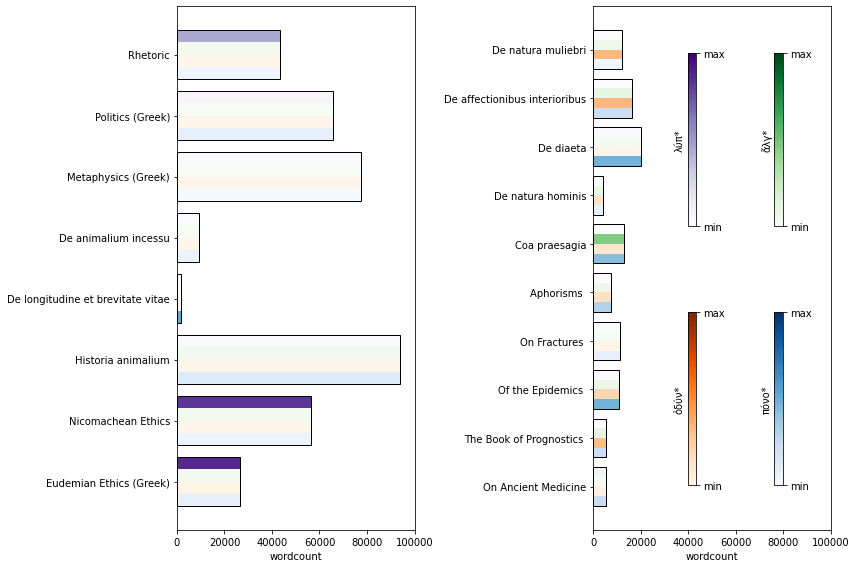

In [17]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# alternatively, choose 10 workds with maximal weighted sum of pain terms
#c_aristotelicum_10 = c_aristotelicum.sort_values("weighted_sum", ascending=False)[:10][::-1]
#c_hippocraticum_10 = c_hippocraticum.sort_values("weighted_sum", ascending=False)[:10][::-1]

# preproducing the figure object
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12, 8), tight_layout=True)

# CORPUS ARISTOTELICUM
labels = [title.partition(";")[0].partition(".")[0] for title in c_aristotelicum_10["title"].tolist()]
wordcounts = c_aristotelicum_10["wordcount"]
y = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

bar_location = 0
for keyterm, colormap in [("λύπ*", "Purples"), ("ἄλγ*", "Greens"), ("ὀδύν*", "Oranges"),	("πόνο*", "Blues")]:
  coloring = c_aristotelicum_10[keyterm + "_weighted"] / c_aristotelicum_10["weighted_sum"].max()
  ax1.barh(y + 0.3 - bar_location, wordcounts, width, color=plt.get_cmap(colormap)(coloring), label=keyterm)
  bar_location = bar_location + 0.2
ax1.barh(y, wordcounts, width * 4, color="none", edgecolor="black")
#rects2 = ax.barh(x + width/2, lemmata_wordcounts_1, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xlabel("wordcount")
#ax1.set_ylabel("documents")
ax1.set_yticks(y)
ax1.set_yticklabels(labels)
ax1.set_xlim(0, 100000)
# ax.legend()

# CORPUS HIPPOCRATICUM
labels = [title.partition(";")[0].partition(".")[0] for title in c_hippocraticum_10["title"].tolist()]
wordcounts = c_hippocraticum_10["wordcount"]
y = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

bar_location = 0
for keyterm, colormap in [("λύπ*", "Purples"), ("ἄλγ*", "Greens"), ("ὀδύν*", "Oranges"),	("πόνο*", "Blues")]:
  coloring = c_hippocraticum_10[keyterm + "_weighted"] / c_hippocraticum_10["weighted_sum"].max()
  cmap = plt.get_cmap(colormap)
  ax2.barh(y + 0.3 - bar_location, wordcounts, width, color=cmap(coloring), label=keyterm)
  bar_location = bar_location + 0.2



ax2.barh(y, wordcounts, width * 4, color="none", edgecolor="black")


#rects2 = ax.barh(x + width/2, lemmata_wordcounts_1, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xlabel("wordcount")
#ax2.set_ylabel("documents")
ax2.set_yticks(y)
ax2.set_yticklabels(labels)
ax2.set_xlim(0, 100000)
# ax.legend()

cblocs =    [[0.8, 0.6, 0.01, 0.3],# [left, bottom, width, height]
             [0.9, 0.6, 0.01, 0.3],
             [0.8, 0.15, 0.01, 0.3],
             [0.9, 0.15, 0.01, 0.3]
]

for keyterm, colormap, location in [("λύπ*", "Purples", cblocs[0]), ("ἄλγ*", "Greens", cblocs[1]), ("ὀδύν*", "Oranges", cblocs[2]),	("πόνο*", "Blues", cblocs[3])]:
  cmap = plt.get_cmap(colormap)
  sm = plt.cm.ScalarMappable(cmap=cmap)
  cbaxes = fig.add_axes(location) # [left, bottom, width, height]
  cb = plt.colorbar(sm, cax=cbaxes) #shrink=0.2) #, ticks=np.arange(0,n))
  cb.set_ticks([0,1])
  cb.set_ticklabels(["min", "max"])
  cb.set_label(keyterm, labelpad=-50)
  #plt.show()


#fig.tight_layout()

plt.show()

In [18]:
# uncomment to export:
# sddk.write_file("public_data/PIA/terms-colorbar.png", fig, conf)

# Pie charts (probably not used...)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


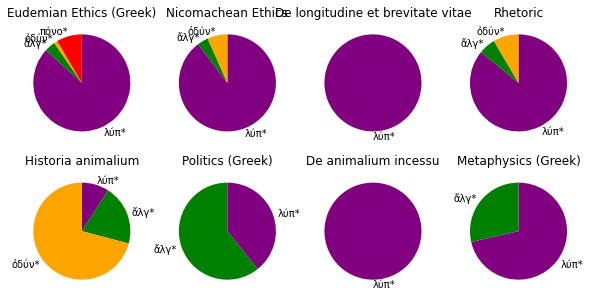

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


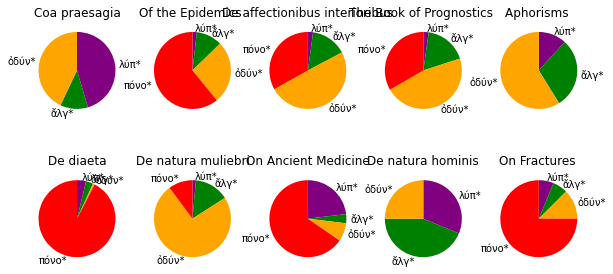

In [19]:
# PIE CHART (OF THE SAME DATA)

c_aristotelicum_10.sort_values("weighted_sum", ascending=False, inplace=True)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
titles = [title.partition(";")[0].partition(".")[0] for title in c_aristotelicum_10["title"].tolist()]
terms = ["λύπ*", "ἄλγ*","ὀδύν*", "πόνο*"]
#values = c_aristotelicum_10.iloc[n][["λύπ*_weighted", "ἄλγ*_weighted", "ὀδύν*_weighted", "πόνο*_weighted"]].tolist()


fig, axs  = plt.subplots(2, 4, figsize=(10,5))

for ax, n, title in zip(axs.ravel(), range(8), titles):
  values = c_aristotelicum_10.iloc[n][["λύπ*_weighted", "ἄλγ*_weighted", "ὀδύν*_weighted", "πόνο*_weighted"]].tolist()
  sizes = [val / c_aristotelicum_10.iloc[n]["weighted_sum"] * 100 for val in  values if val > 0]
  #labels = [term_value[0] + "(" + str(np.round(term_value[1], 4)) + ")" for term_value in zip(terms, values)]
  labels = terms
  ax.pie(sizes, colors=["purple", "green", "orange", "red"], labels=labels[:len(sizes)], startangle=90, counterclock=False)
  ax.set_title(title, wrap=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


c_hippocraticum_10.sort_values("weighted_sum", ascending=False, inplace=True)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
titles = [title.partition(";")[0].partition(".")[0] for title in c_hippocraticum_10["title"].tolist()]
terms = ["λύπ*", "ἄλγ*","ὀδύν*", "πόνο*"]
values = c_hippocraticum_10.iloc[n][["λύπ*_weighted", "ἄλγ*_weighted", "ὀδύν*_weighted", "πόνο*_weighted"]].tolist()
fig, axs  = plt.subplots(2, 5, figsize=(10,5))


for ax, n, title in zip(axs.ravel(), range(10), titles):
  values = c_hippocraticum_10.iloc[n][["λύπ*_weighted", "ἄλγ*_weighted", "ὀδύν*_weighted", "πόνο*_weighted"]].tolist()
  sizes = [val / c_hippocraticum_10.iloc[n]["weighted_sum"] * 100 for val in  values if val > 0]
  #labels = [term_value[0] + "(" + str(np.round(term_value[1], 4)) + ")" for term_value in zip(terms, values)]
  labels = terms
  ax.pie(sizes, colors=["purple", "green", "orange", "red"], labels=labels[:len(sizes)], startangle=90, counterclock=False)
  ax.set_title(title, wrap=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Combined barplot


In [20]:
category_colors = ["Purple", "Green", "Blue", "Red"]

In [21]:
def plot_ratios(corpus_df):
  data = {}
  for n in range(len(corpus_df)):
    label = corpus_df.iloc[n]["title"].partition(";")[0].partition(".")[0] + " (" + str(corpus_df.iloc[n]["wordcount"]) + " words)"
    counts = corpus_df.iloc[n][["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]].tolist()
    values = corpus_df.iloc[n][["λύπ*_weighted", "ἄλγ*_weighted", "ὀδύν*_weighted", "πόνο*_weighted"]].tolist()
    values = [0 if math.isnan(x) else x for x in values]
    ratios = [val / corpus_df.iloc[n]["weighted_sum"] * 100 for val in  values] # if val > 0]
    ratios = [0 if math.isnan(x) else x for x in ratios]
    data[label] = (counts, ratios)

  labels = list(data.keys())
  counts = np.array([el[0] for el in list(data.values())])
  ratios = np.array([el[1] for el in list(data.values())])
  ratios_cum = ratios.cumsum(axis=1)

  category_colors = ["Purple", "Green", "Blue", "Red"]

  terms = ["λύπ*", "ἄλγ*","ὀδύν*", "πόνο*"]


  fig, ax = plt.subplots(figsize=(12, len(corpus_df)/4 + 1), tight_layout=True)
  ax.invert_yaxis()
  ax.xaxis.set_visible(False)

  ax.set_xlim(0, np.sum(ratios, axis=1).max())
  ax.set_ylim(-0.5, len(corpus_df) - 0.5)

  for i, (term, color) in enumerate(zip(terms, category_colors)):
          widths = ratios[:, i]
          texts = counts[:, i]
          starts = ratios_cum[:, i] - widths
          ax.barh(labels, widths, left=starts,
                  label=term, color=color)
          xcenters = starts + widths / 2
          for y, (x, c) in enumerate(zip(xcenters, texts)):
              if int(c) > 0:
                ax.text(x, y, str(int(c)), ha='center', va='center', color='white')
              else:
                ax.text(x, y, "", ha='center', va='center', color='white')
  ax.legend(ncol=len(terms), bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
  return fig

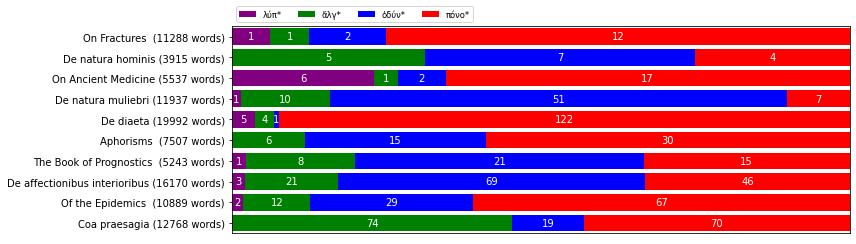

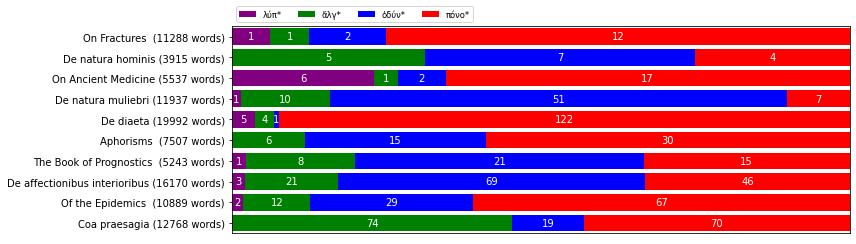

In [22]:
plot_ratios(c_hippocraticum_10)

In [23]:
# uncomment to generate figures & export them to sciencedata
# sddk.write_file("public_data/PIA/ratios_c_aristotelicum.png", plot_ratios(c_aristotelicum), conf)
# sddk.write_file("public_data/PIA/ratios_c_aristotelicum_10.png", plot_ratios(c_aristotelicum_10), conf)
# sddk.write_file("public_data/PIA/ratios_c_hippocraticum.png", plot_ratios(c_hippocraticum), conf)
# sddk.write_file("public_data/PIA/ratios_c_hippocraticum_10.png", plot_ratios(c_hippocraticum_10), conf)

# Work types / document clustering

In [24]:
c_hip_metadata = PIA_overview.worksheet("c_hip_metadata").get_all_records()
c_hip_cat_dict = {pair["doc_id"] : pair["work_category"] for pair in c_hip_metadata}
print(c_hip_cat_dict)

{'tlg0627.tlg001': 'H', 'tlg0627.tlg002': 'C', 'tlg0627.tlg003': 'D', 'tlg0627.tlg004': 'D', 'tlg0627.tlg005': '', 'tlg0627.tlg006': 'B', 'tlg0627.tlg007': 'A', 'tlg0627.tlg008': '', 'tlg0627.tlg009': 'A', 'tlg0627.tlg010': 'A', 'tlg0627.tlg011': 'A', 'tlg0627.tlg012': 'E', 'tlg0627.tlg013': '', 'tlg0627.tlg014': '', 'tlg0627.tlg015': 'B', 'tlg0627.tlg016': '', 'tlg0627.tlg017': '', 'tlg0627.tlg018': '', 'tlg0627.tlg019': 'H', 'tlg0627.tlg020': '', 'tlg0627.tlg021': '', 'tlg0627.tlg022': '', 'tlg0627.tlg023': '', 'tlg0627.tlg024': '', 'tlg0627.tlg025': '', 'tlg0627.tlg026': '', 'tlg0627.tlg027': 'C', 'tlg0627.tlg028': '', 'tlg0627.tlg029': '', 'tlg0627.tlg030': '', 'tlg0627.tlg031': 'G', 'tlg0627.tlg032': 'F', 'tlg0627.tlg033': 'F', 'tlg0627.tlg035': '', 'tlg0627.tlg036': 'F', 'tlg0627.tlg037': 'F', 'tlg0627.tlg038': '', 'tlg0627.tlg039': '', 'tlg0627.tlg040': '', 'tlg0627.tlg041': '', 'tlg0627.tlg042': '', 'tlg0627.tlg043': 'G', 'tlg0627.tlg045': '', 'tlg0627.tlg046': '', 'tlg0627.tlg